# Make correlated Gaussian realisations given some underlying spectrum.

In [4]:
%load_ext autoreload
%autoreload 2


In [5]:
import numpy as np, sys, os, warnings
sys.path.append('../simulations')
import flatsky

from pylab import *
cmap = cm.RdYlBu_r


In [6]:
rcParams['figure.dpi'] = 150
rcParams["figure.facecolor"] = 'white'

In [17]:
#get params for sim generation
lmin = 200 #remove some largest-scale modes
lmax = 10000
els = np.arange(lmax)

#min_tim_band, max_tim_band, delta_tim_band = 715, 1200, 4
#min_tim_band, max_tim_band, delta_tim_band = 700, 900, 10
#min_tim_band, max_tim_band, delta_tim_band = 700, 760, 10
min_tim_band, max_tim_band, delta_tim_band = 700, 820, 20
band_arr = np.arange( min_tim_band, max_tim_band, delta_tim_band )
total_bands = len( band_arr )
print( len(band_arr) )

#map dimensions
boxsize_degrees = 3.
pixel_res_arcsecs = 20.

ny = nx = int( boxsize_degrees * 3600. / pixel_res_arcsecs )
map_shape = [ny, nx]
print( map_shape )
pixel_res_radians = np.radians( pixel_res_arcsecs/3600. )

#sims
total_sims = 5


6
[540, 540]


In [18]:
#define theory spectra now
#This will be modified based on TIM's noise model.

#some dummy noise model for now
elknee, alphaknee = 3000., 4.
noise_dic = {}
for band in band_arr:    
     noise_dic[band] = 100. #uK-arcmin like in CMB. Need to modify to flux units later.

rho = 0.05 ##0.9 #correlation cofficient for atmospheric noise
rho = np.tile(rho, len(els))
#rho(ell) -- modelled as a Gaussian
if (0):
    rho = np.exp( - (els**2)/(2 * 1500**2) )
    rho = rho / max(rho)
    plot( els, rho ); show()
rho[np.isnan(rho) | np.isinf(rho)] = 0.

nl_dic = {}

#autos first
nl_atm_dic = {}
for band in band_arr:

    #white
    delta_T_radians = noise_dic[band] * np.radians(1./60.)
    curr_nl_white = np.tile(delta_T_radians**2., len(els) )

    #atm
    curr_nl_atm = np.copy(curr_nl_white) * (elknee * 1./els)**alphaknee
    #curr_nl_atm = np.copy(curr_nl_white) * (els)**-0.05
    curr_nl_atm[np.isinf(curr_nl_atm) | np.isnan(curr_nl_atm) ] = 0.
    nl_atm_dic[(band, band)] = curr_nl_atm

    #total
    curr_nl = curr_nl_white + curr_nl_atm
    curr_nl[np.isinf(curr_nl) | np.isnan(curr_nl) ] = 0.
    nl_dic[(band, band)] = curr_nl
    
    if (0): 
        ax = subplot(111, yscale = 'log')
        plot( els, curr_nl); #ylim(1e-6, 1e-4)
        show(); sys.exit()

#crosses
for band1 in band_arr:
    for band2 in band_arr:
        if band1 == band2: continue

        if (1): #only corr atm noise
            curr_nl_band1 = nl_atm_dic[(band1, band1)]
            curr_nl_band2 = nl_atm_dic[(band2, band2)]
        if (0): #"all" corr noise 
            curr_nl_band1 = nl_dic[(band1, band1)]
            curr_nl_band2 = nl_dic[(band2, band2)]
        
        curr_nl_band1_band2 = rho * np.sqrt( curr_nl_band1 * curr_nl_band2 )
        ##print( curr_nl_band1 ); 
        ##print( curr_nl_band2 )
        ##print( curr_nl_band1_band2 )
        ##sys.exit()
        
        nl_dic[(band1, band2)] = curr_nl_band1_band2

for b1b2 in nl_dic: #remove nans, inf, and largest-scale modes
    curr_nl = nl_dic[b1b2]
    curr_nl[np.isnan(curr_nl) | np.isinf(curr_nl)] = 0.
    curr_nl[els<lmin] = 0.
    nl_dic[b1b2] = curr_nl
    
##print( nl_dic ); sys.exit()

/var/folders/08/mkcy0rls72j2q09krs7qx2jw0000gn/T/ipykernel_7459/4113319062.py:30: RuntimeWarning: divide by zero encountered in true_divide
  curr_nl_atm = np.copy(curr_nl_white) * (elknee * 1./els)**alphaknee


dict_keys([(0, 0), (0, 1), (1, 0), (0, 2), (2, 0), (0, 3), (3, 0), (0, 4), (4, 0), (0, 5), (5, 0), (1, 1), (1, 2), (2, 1), (1, 3), (3, 1), (1, 4), (4, 1), (1, 5), (5, 1), (2, 2), (2, 3), (3, 2), (2, 4), (4, 2), (2, 5), (5, 2), (3, 3), (3, 4), (4, 3), (3, 5), (5, 3), (4, 4), (4, 5), (5, 4), (5, 5)])
Sim = 1 of 5


/Users/sraghunathan/Research/TIM/TIM_analysis/tutorials/../simulations/flatsky.py:192: RuntimeWarning: invalid value encountered in true_divide
  tij_dic[(i,j)] = (t1-t2)/t3


(6, 540, 540)


<Figure size 900x600 with 0 Axes>

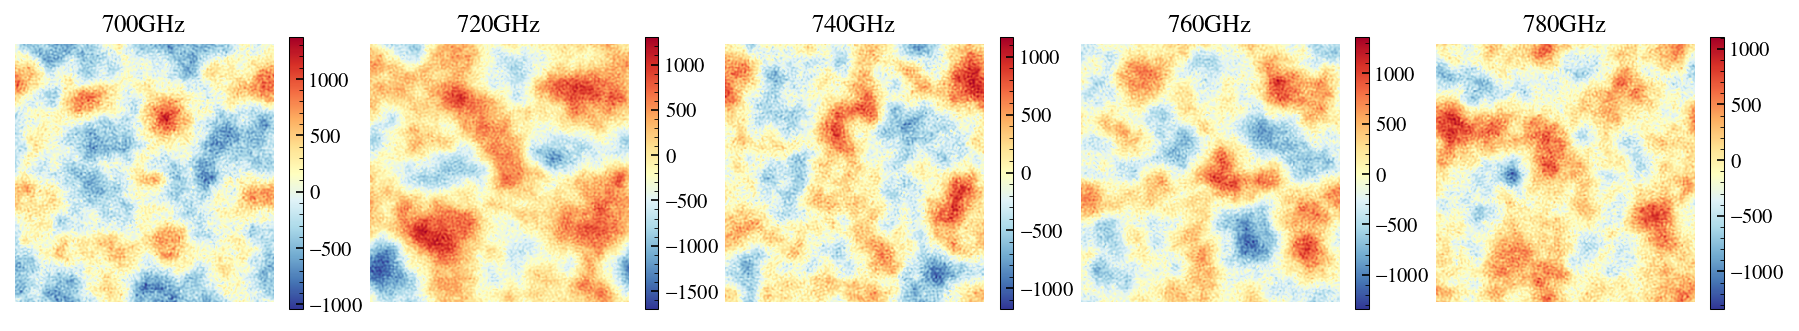

	 sim shape =  (6, 540, 540)


/Users/sraghunathan/Research/TIM/TIM_analysis/tutorials/../simulations/flatsky.py:408: ComplexWarning: Casting complex values to real discards the imaginary part
  radprf[b,1]=np.sum(z[ind])/hits


Sim = 2 of 5
(6, 540, 540)
	 sim shape =  (6, 540, 540)
Sim = 3 of 5
(6, 540, 540)
	 sim shape =  (6, 540, 540)
Sim = 4 of 5
(6, 540, 540)
	 sim shape =  (6, 540, 540)
Sim = 5 of 5
(6, 540, 540)
	 sim shape =  (6, 540, 540)


Sims complete.


In [19]:
#make sims now

#create the cl_dict (which is nl_dic_for_sims) for the sim code.
nl_dic_for_sims = {}
for b1cntr, band1 in enumerate( band_arr ):
    for b2cntr, band2 in enumerate( band_arr ):
        if band2<band1: continue
        nl_dic_for_sims[(b1cntr, b2cntr)] = nl_dic[(band1, band2)]
        nl_dic_for_sims[(b2cntr, b1cntr)] = nl_dic[(band1, band2)]
print(nl_dic_for_sims.keys()); ##sys.exit()

nl_dic_sims = {}
for sim_no in range( total_sims ):
    print('Sim = %s of %s' %(sim_no+1, total_sims))
    noise_sim_arr = flatsky.make_gaussian_realisations(els, nl_dic_for_sims, map_shape, pixel_res_radians)
    print( noise_sim_arr.shape ); ##sys.exit()
    
    '''
    #apply apod mask
    noise_sim_arr = noise_sim_arr * apod_mask
    for cntr in range(len(noise_sim_arr)):
        noise_sim_arr[cntr] = noise_sim_arr[cntr] - np.mean( noise_sim_arr[cntr] )
    ##print( np.mean(noise_sim_arr, axis = (1,2)) ); sys.exit()
    '''
    
    if sim_no == 0: #show first 5 band maps as an example
        clf()
        '''
        tr = 5
        tc = int( total_bands / tr ) + 1
        '''
        figure(figsize = (15., 4.))
        tr, tc = 1, 5
        subplots_adjust(wspace = 0.1)
        to_plot_arr = noise_sim_arr[:5]
        for cntr in range( len(to_plot_arr) ):
            subplot(tr, tc, cntr+1); 
            imshow(noise_sim_arr[cntr], cmap = cmap); 
            colorbar(shrink = 0.6)
            axis('off')
            title(r'%sGHz' %(band_arr[cntr]))
        show(); ##sys.exit()
    print( '\t sim shape = ', noise_sim_arr.shape ); ##sys.exit()

    #get the sim spectra now.
    curr_sim_nl_dic = {}
    for (band1, map1) in zip( band_arr, noise_sim_arr ):
        for (band2, map2) in zip( band_arr, noise_sim_arr ):
            if band2<band1: continue
            els_sim, cl_sim = flatsky.map2cl(map_shape, pixel_res_radians, map1, map2, minbin = lmin, maxbin = lmax)
            curr_sim_nl_dic[(band1, band2)] = [els_sim, cl_sim]
    nl_dic_sims[sim_no] = curr_sim_nl_dic
    
print('\n\nSims complete.')

[700, 700] 0 0
[720, 720] 1 1
[740, 740] 2 2
[760, 760] 3 3
[780, 780] 4 4
[800, 800] 5 5
[700, 720] 0 1
[700, 740] 0 2
[700, 760] 0 3
[700, 780] 0 4
[700, 800] 0 5
[720, 740] 1 2
[720, 760] 1 3
[720, 780] 1 4
[720, 800] 1 5
[740, 760] 2 3
[740, 780] 2 4
[740, 800] 2 5
[760, 780] 3 4
[760, 800] 3 5
[780, 800] 4 5


<Figure size 900x600 with 0 Axes>

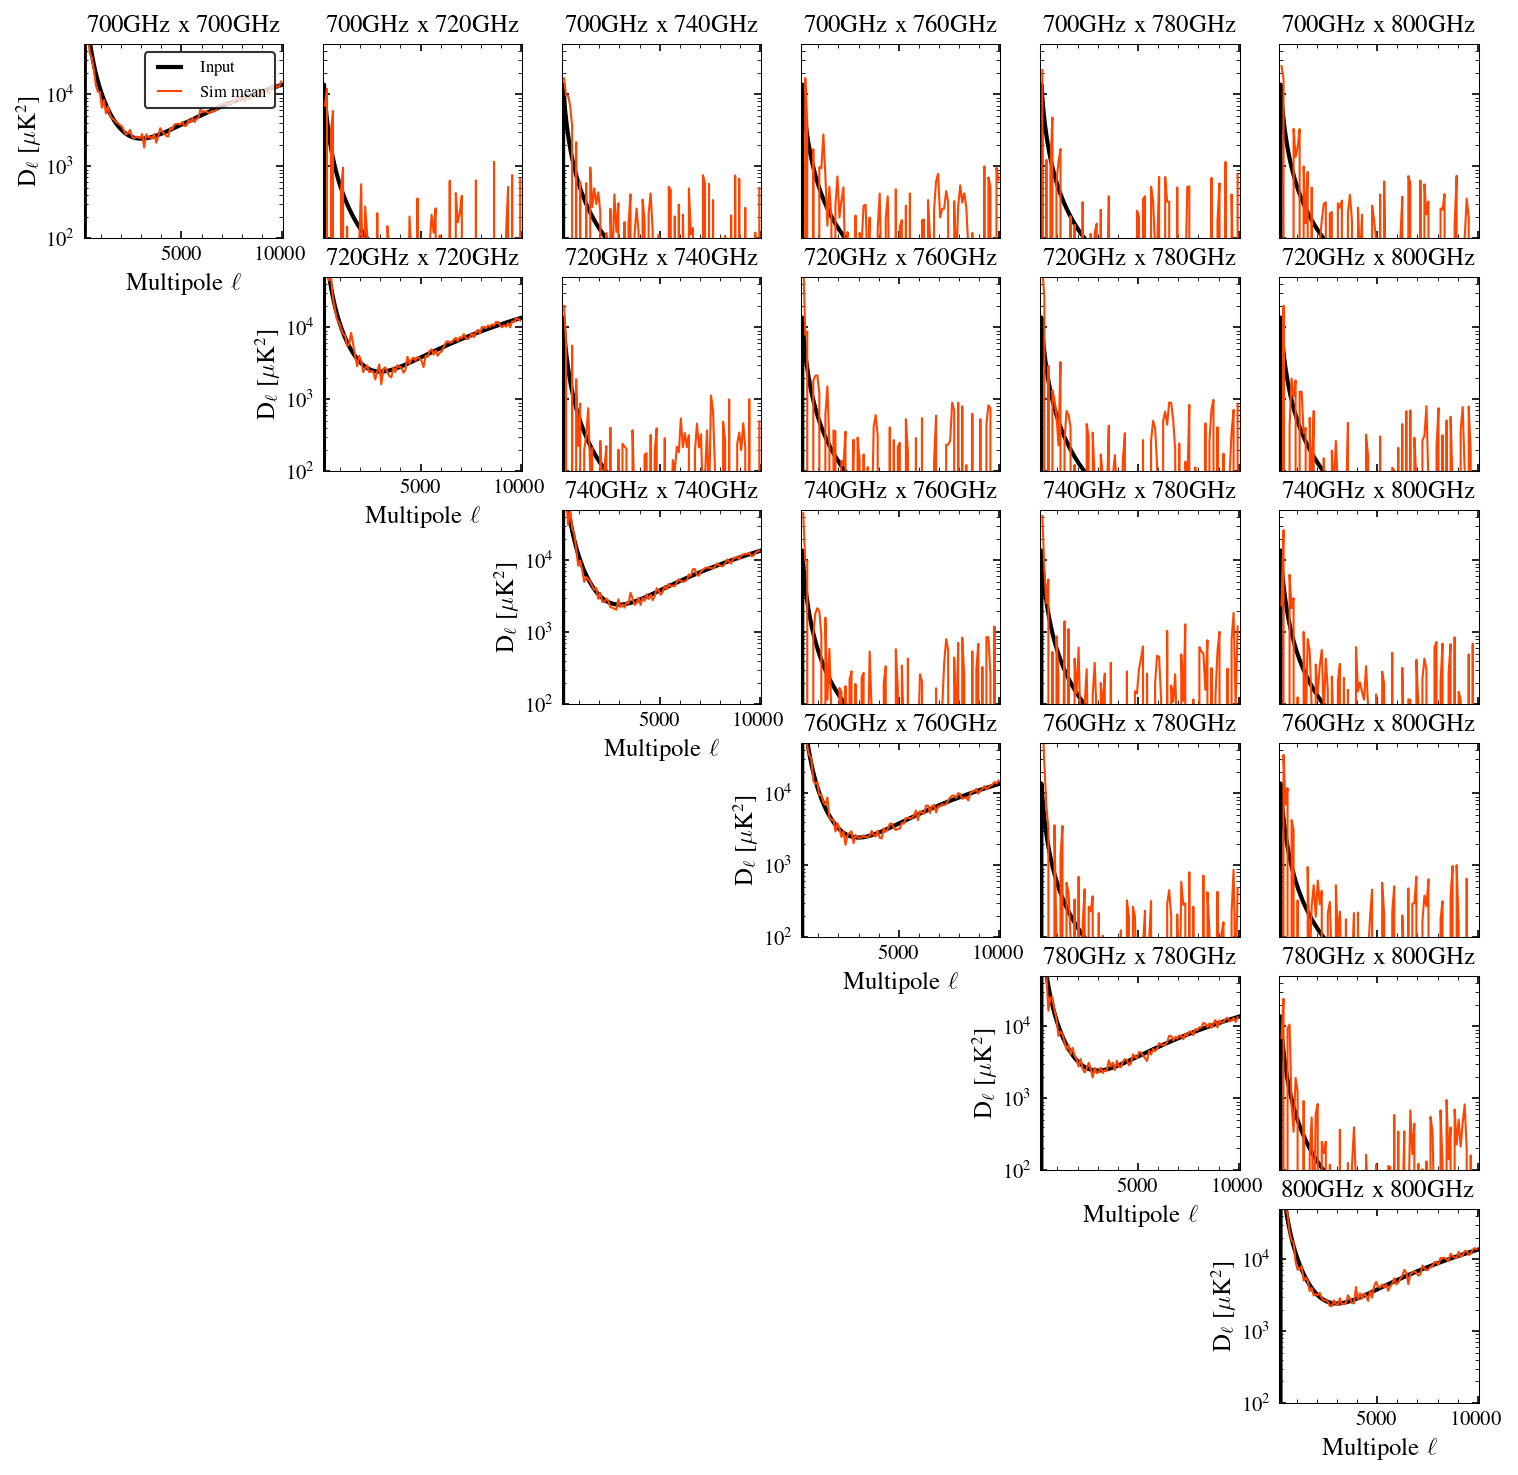

In [16]:
#make plots of the input vs output power spectra.
band_arr_to_plot = np.asarray( band_arr )
if total_bands > 5:
    band_arr_to_plot = band_arr_to_plot[:8]
band_combs_for_plotting_autos = [[band, band] for band in band_arr_to_plot]
band_combs_for_plotting_crosses = [[band1, band2] for band1 in band_arr_to_plot for band2 in band_arr_to_plot if (band1!=band2 and band1<band2)]
band_combs_for_plotting = band_combs_for_plotting_autos + band_combs_for_plotting_crosses

close('all')
clf()
fsval = 12
tr, tc = len(band_arr_to_plot), len(band_arr_to_plot)
subplots_adjust( hspace = 0.2, wspace = 0.1)
sbpl = 1
dl_fac = els * (els+1)/2/np.pi

figure(figsize = (tr+6, tc+6))

for b1b2 in band_combs_for_plotting:
    b1, b2 = b1b2

    rowval, colval = np.where(band_arr_to_plot == b1)[0][0], np.where(band_arr_to_plot == b2)[0][0]
    print(b1b2, rowval, colval)
    ax = subplot2grid((tr, tc), (rowval, colval), yscale = 'log')

    curr_nl = nl_dic[(b1, b2)]
    #theory
    plot( els, dl_fac * curr_nl, color = 'black', label = r'Input', lw = 2.)

    #sims
    colorval = 'orangered'
    curr_nl_arr = []
    for sim_no in nl_dic_sims:
        curr_el, curr_nl = nl_dic_sims[sim_no][(b1, b2)]
        curr_nl_arr.append( curr_nl )
        curr_dl_fac = curr_el * (curr_el+1)/2/np.pi
        plot( curr_el, curr_dl_fac * curr_nl, color = colorval, lw = 0.2, alpha = 0.5)
    curr_nl_mean = np.mean( curr_nl_arr, axis = 0 )
    plot( curr_el, curr_dl_fac * curr_nl_mean, color = colorval, label = r'Sim mean')


    xlim(lmin-50, lmax+50); ylim(100., 5e4)
    if rowval == colval:
        xlabel(r'Multipole $\ell$', fontsize = fsval)
        ylabel(r'D$_{\ell}$ [$\mu$K$^{2}$]', fontsize = fsval)
    else:
        setp(ax.get_xticklabels(), visible=False);# tick_params(axis='y',left='off')
        setp(ax.get_yticklabels(), visible=False);# tick_params(axis='y',left='off')

    if rowval == colval and rowval == 0:
        legend(loc = 1, fontsize = fsval - 4, ncol = 1)

    title(r'%sGHz x %sGHz' %(b1, b2), fontsize = fsval)

    sbpl += 1

show()